In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor

In [2]:
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values(0) <= split_date].copy(), \
           data.loc[data.index.get_level_values(0) >  split_date].copy()

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

#### 1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями

In [3]:
data = pd.read_csv('my_BRENT2019.csv', index_col=[0], parse_dates=[0])

In [4]:
df = data.copy()

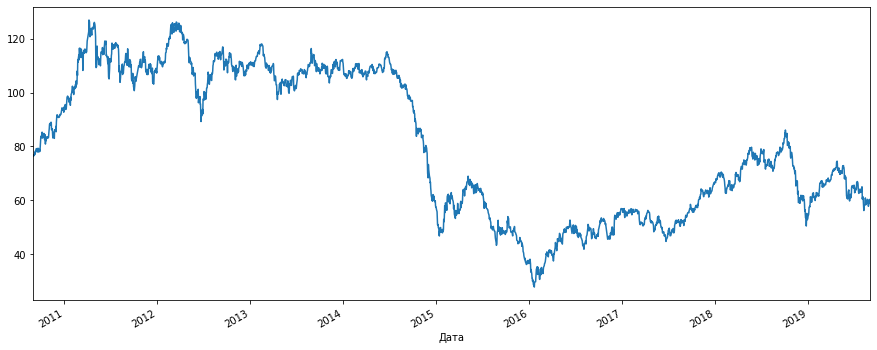

In [5]:
df['Значение'].plot(figsize=(15, 6))

In [6]:
new_dates = pd.date_range('2011-10-10', '2011-10-19', freq="D")
df_add = pd.DataFrame(index=new_dates)
df_add['Значение'] = (104.13+109.93) / 2
df = df.append(df_add)
df.sort_index(inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [7]:
df.fillna(method='pad', inplace=True)

In [8]:
df['Значение'] = df['Значение'].diff().fillna(0)

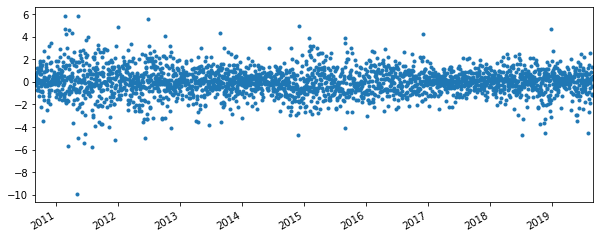

In [9]:
df['Значение'].plot(figsize=(10, 4), style='.')

#### 2. Добавьте первые разности по стоимости доллара и евро к рублю

In [10]:
df_usd = pd.read_excel('RC_F01_09_2010_T01_09_2019_usd.xlsx', index_col=[1], parse_dates=[1])
df_usd.drop(['nominal', 'cdx'], axis=1, inplace=True)
df_usd['usd_diff1'] = df_usd['curs'].diff().fillna(0)

In [11]:
df_eur = pd.read_excel('RC_F01_09_2010_T01_09_2019_eur.xlsx', index_col=[1], parse_dates=[1])
df_eur.drop(['nominal', 'cdx'], axis=1, inplace=True)
df_eur['eur_diff1'] = df_eur['curs'].diff().fillna(0)

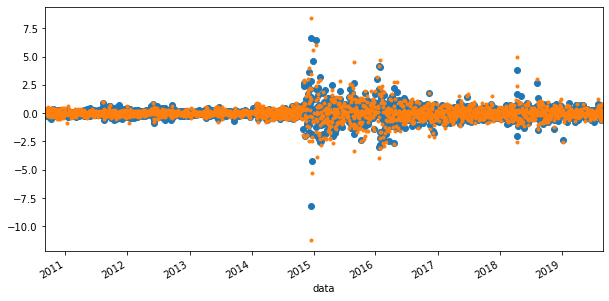

In [12]:
df_usd['usd_diff1'].plot(figsize=(10, 5), style='o')
df_eur['eur_diff1'].plot(figsize=(10, 5), style='.')

В курсах валют отсутствуют данные за выходные дни и новогодние праздники, поэтому сначала сделаем ресемплинг датасетов отдельно, а после соединим

In [13]:
df_eur = df_eur.resample('W').mean()
df_usd = df_usd.resample('W').mean()
df = df.resample('W').mean()

In [14]:
df_eur.fillna(method='pad', inplace=True)
df_usd.fillna(method='pad', inplace=True)

In [15]:
df = df.merge(df_eur['eur_diff1'], left_index=True, right_index=True)
df = df.merge(df_usd['usd_diff1'], left_index=True, right_index=True)

#### 3. Cделайте ее перрасчет (ресемплинг) в представление по неделям

In [16]:
df = df[['Значение', 'year', 'weekofyear', 'eur_diff1', 'usd_diff1']]

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 470 entries, 2010-09-05 to 2019-09-01
Freq: W-SUN
Data columns (total 5 columns):
Значение      470 non-null float64
year          470 non-null float64
weekofyear    470 non-null float64
eur_diff1     470 non-null float64
usd_diff1     470 non-null float64
dtypes: float64(5)
memory usage: 42.0 KB


#### 4. Постройте модель предсказания 1-й точки от текущей (h=1).

In [18]:
# steps = np.linspace(0.01, 0.09, 5).round(2)
# for step in steps:
#     df['val_exp_'+str(step)] = exponential_smoothing(df['Значение'], step)
#     df['eur_exp_'+str(step)] = exponential_smoothing(df['eur_diff1'], step)
#     df['usd_exp_'+str(step)] = exponential_smoothing(df['usd_diff1'], step)    

In [19]:
h = 1
train, test = split_data(df, '01-01-2018')
X_train = train.iloc[:-h, :]
y_train = train['Значение'].values[h:]
X_test = test.iloc[:-h, :]
y_test = test['Значение'].values[h:]

In [29]:
model_gb = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model_gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [30]:
y_pred = model_gb.predict(X_test)

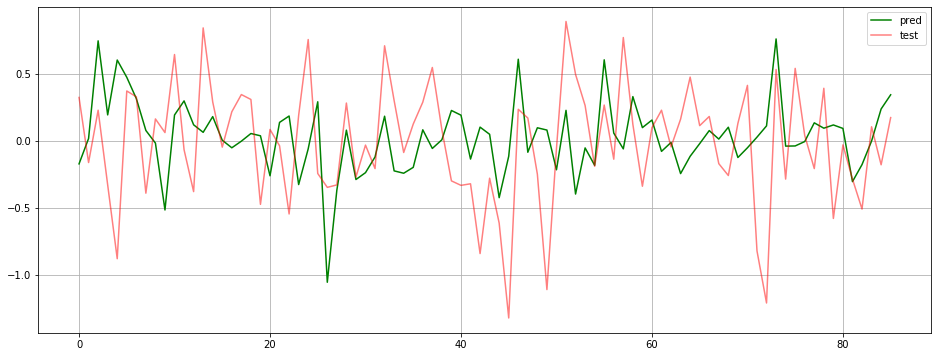

In [31]:
plt.figure(figsize=(16,6))
plt.plot(y_pred, '-g', label='pred')
plt.plot(y_test, '-r', label='test', alpha=0.5)
plt.grid()
plt.legend()

In [32]:
mean_absolute_percentage_error(y_test, y_pred)

148.30769371548197

Получили какую-то чудовищную ошибку

In [33]:
import statsmodels.api as sm

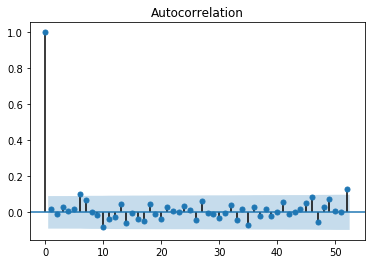

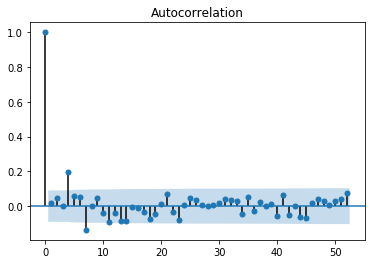

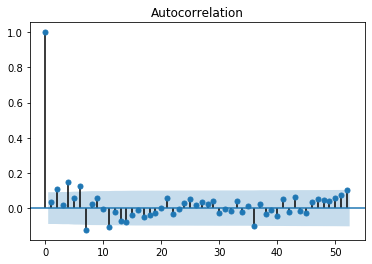

In [49]:
sm.graphics.tsa.plot_acf(df['Значение'].values, lags=52)
plt.show()
sm.graphics.tsa.plot_acf(df['eur_diff1'].values, lags=52)
plt.show()
sm.graphics.tsa.plot_acf(df['usd_diff1'].values, lags=52)
plt.show()

По сути мы имеем первые разности, то есть PACF от нашего изначального ряда с реальными значениями. И особой информации отсюда мы получить не можем.

In [52]:
df.corr().style.background_gradient(cmap='coolwarm')

,Значение,year,weekofyear,eur_diff1,usd_diff1
Значение,1,-0.0209218,-0.0853355,-0.250757,-0.311982
year,-0.0209218,1,-0.143283,-0.014064,-0.00617138
weekofyear,-0.0853355,-0.143283,1,0.0258282,0.0379567
eur_diff1,-0.250757,-0.014064,0.0258282,1,0.918623
usd_diff1,-0.311982,-0.00617138,0.0379567,0.918623,1


Целевая переменная тоже ни с чем не коррелирует.

In [54]:
from sklearn.linear_model import LinearRegression

In [55]:
model_l = LinearRegression()

In [57]:
model_l.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [58]:
y_pred_l = model_l.predict(X_test)

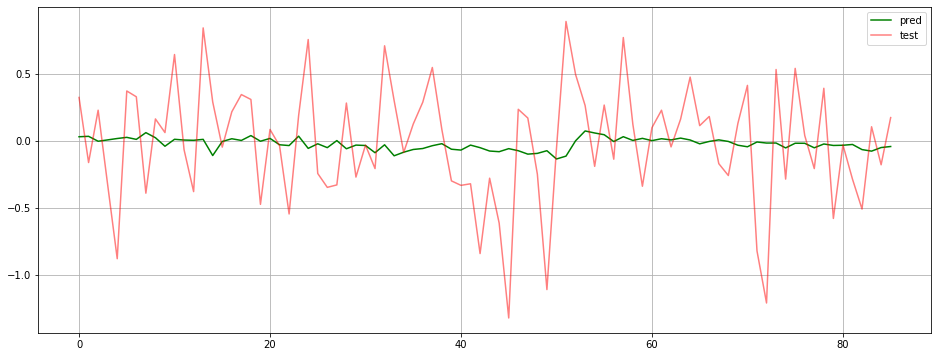

In [62]:
plt.figure(figsize=(16,6))
plt.plot(y_pred_l, '-g', label='pred')
plt.plot(y_test, '-r', label='test', alpha=0.5)
plt.grid()
plt.legend()

In [61]:
mean_absolute_percentage_error(y_test, y_pred_l)

98.43943334523692

Мы получили лучший результат (хотя и всё равно плохой) с более простой моделью. По сути это обычное усреднение. <br>
<b> Делаю следующий вывод: </b> Ряды по потреблению энергии и цен на нефть фундаментально различаются и требуют разных подходов. <br>
Ряд потребления энергии достаточно прост в интерпретации и имеет под собой некую "физическую" природу. Сам ряд дает нам очень много эндогенной информации и его поведение в целом предсказуемо (кроме сценариев прорыва в мире энергетики или аварий никаких сюрпризов быть не может). Мы можем делать предсказания по ряду, основываясь на самом ряде<br>
Колебания цен на нефть слишком зависимы от внешних факторов. Ряд сам по себе не дает нам достаточно информации для успешного анализа. Модели, которые мы строили по Brent работали по сути как предсказание по предыдущему значению, либо как некое усреднение